In [ ]:
!pip install catboost
!pip install shap
!pip install optuna

# 라이브러리

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap
import optuna
import warnings

# 데이터

## target 데이터 생성

In [ ]:
data_5m = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_upper_5M_data.csv")
data_test = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_test_data.csv")
data_train = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_train_data.csv")

5m이상을 target = 1로 정의

In [ ]:
data_5m["target"] = 1
data_test["target"] = 0
data_train["target"] = 0
data_full = pd.concat([data_5m, data_test, data_train], axis=0).reset_index(drop=True)

## 범주형 변수 지정

In [ ]:
cat_features = ['Grade', 'Main_Country', 'Pandemic']

## 데이터 분할

총 관람객 수, 총 상영일수 횟수, 총 상영 주차는 종속변수이므로 제거한다

In [ ]:
movie_titles = data_full['Movie_Title']

In [ ]:
X = data_full.drop(['Movie_Title', 'Total_Audience_Count', 'target', "Total_Show_Days", "Total_Weeks"], axis=1)
y = data_full['target']
# target(y)를 기준으로 계층 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. CatBoost 사용

## 1) 초기 구동

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    verbose=100,  # 100번마다 학습 로그 출력
    task_type='GPU',  # GPU 사용 설정
    devices='0',       # 첫 번째 GPU 사용
    cat_features=cat_features # 범주형 변수 지정
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)[:, 1] # 1이 될 확률
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Probability_of_Success': prediction_probs
})
test_titles = movie_titles.loc[X_test.index]
results_df['Movie_Title'] = test_titles.values

Learning rate set to 0.060206
0:	learn: 0.5360898	total: 35.9ms	remaining: 17.9s
100:	learn: 0.0022413	total: 3.39s	remaining: 13.4s
200:	learn: 0.0007821	total: 6.83s	remaining: 10.2s
300:	learn: 0.0004636	total: 10.3s	remaining: 6.83s
400:	learn: 0.0003351	total: 13.7s	remaining: 3.38s
499:	learn: 0.0002632	total: 17.1s	remaining: 0us


In [ ]:
print(results_df.head())

     Actual  Predicted  Probability_of_Success      Movie_Title
476       0          0                0.000019  잠깐만 회사 좀 관두고 올게
786       0          0                0.000166             건국전쟁
491       0          0                0.000030             해바라기
195       0          0                0.000080         여배우는 오늘도
846       0          0                0.000012              바이스


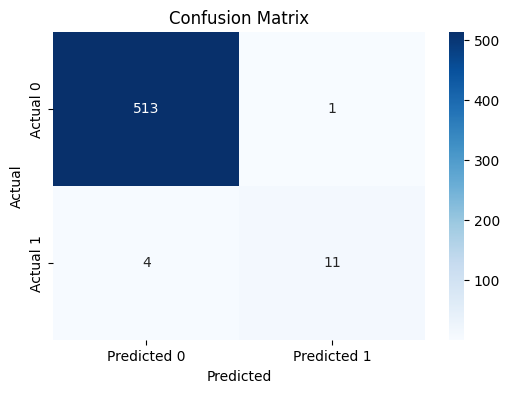

In [ ]:
cm = confusion_matrix(results_df['Actual'], results_df['Predicted'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
misclassified_movies = results_df[results_df['Actual'] != results_df['Predicted']]
pd.merge(data_full[data_full["Movie_Title"].isin(misclassified_movies['Movie_Title'].tolist())][["Movie_Title", "Total_Audience_Count"]], misclassified_movies)

,Movie_Title,Total_Audience_Count,Actual,Predicted,Probability_of_Success
0,과속스캔들,8125843,1,0,0.011986
1,닥터 스트레인지,5327833,1,0,0.253219
2,블랙 팬서,5395971,1,0,0.034519
3,인셉션,5827610,1,0,0.162372
4,박수건달,3887729,0,1,0.843235


## 2) 변수 중요도

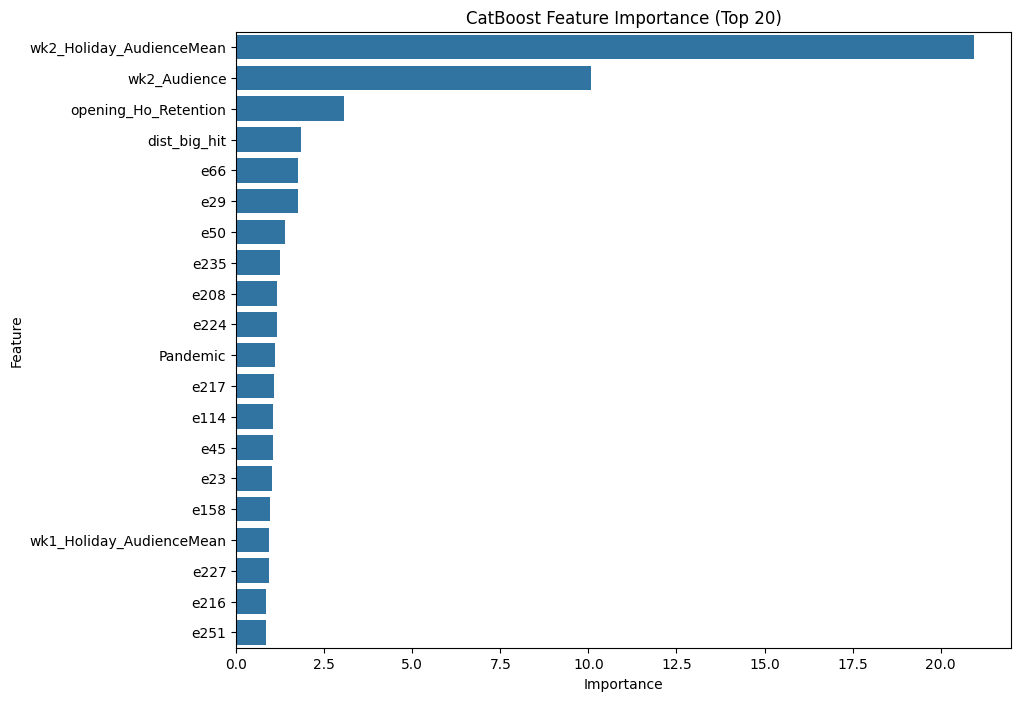

                      Feature  Importance
8    wk2_Holiday_AudienceMean   20.958187
2                wk2_Audience   10.059220
5        opening_Ho_Retention    3.060157
15               dist_big_hit    1.832897
85                        e66    1.761513
48                        e29    1.758990
69                        e50    1.396170
254                      e235    1.230729
227                      e208    1.169893
243                      e224    1.156084
13                   Pandemic    1.091223
236                      e217    1.058140
133                      e114    1.038274
64                        e45    1.035601
42                        e23    1.021919
177                      e158    0.945228
6    wk1_Holiday_AudienceMean    0.939661
246                      e227    0.938701
235                      e216    0.853758
270                      e251    0.851984


In [ ]:
# 1. 변수 중요도 추출
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# 2. 데이터프레임으로 만들기
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 3. 상위 20개 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance (Top 20)')
plt.show()

# 4. 중요도 출력
print(importance_df.head(20))

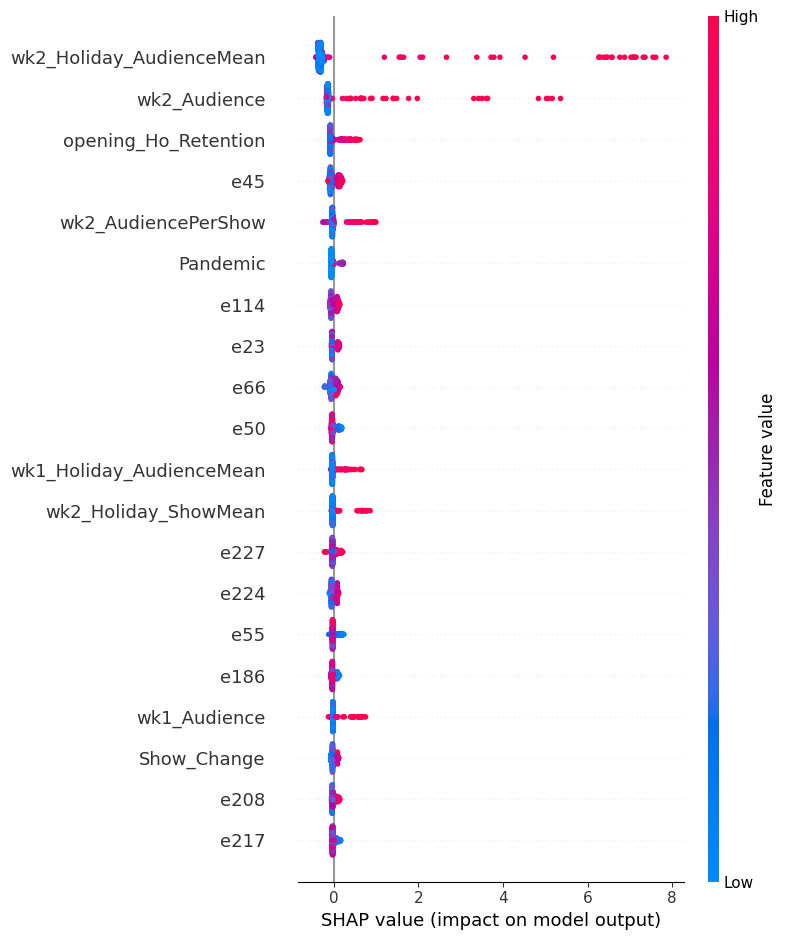

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

1. `wk2_Holiday_AudienceMean`, `wk2_Audience`
2. `opening_Ho_Retention`, `wk2_AudiencePerShow`, `dist_big_hit`, `Pandemic`
3. `wk1_Holiday_AudienceMean`, `wk2_Holiday_ShowMean`, `wk1_Audience`

총 2+4+3의 변수가 유의

## 3) 변수 선택 및 하이퍼파라미터 튜닝

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

In [ ]:
feature_sets = {
    "base_2": ['wk2_Holiday_AudienceMean', 'wk2_Audience'],
    "medium_6": ['wk2_Holiday_AudienceMean', 'wk2_Audience',
                 'opening_Ho_Retention', 'wk2_AudiencePerShow', 'dist_big_hit', 'Pandemic'],
    "full_9": ['wk2_Holiday_AudienceMean', 'wk2_Audience',
                'opening_Ho_Retention', 'wk2_AudiencePerShow', 'dist_big_hit', 'Pandemic',
                'wk1_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'wk1_Audience']
}

embedding_sets = {
    "embed_128": [f'e{i+1}' for i in range(128)],
    "embed_64": [f'e{i+1}' for i in range(64)],
    "embed_32": [f'e{i+1}' for i in range(32)],
    "embed_none" : []
}

tuner_methods = ['optuna', 'random_search']
# tuner_methods = ['random_search', 'optuna']

In [ ]:
results = []
experiment_id = 0
total_experiments = len(feature_sets) * len(embedding_sets) * len(tuner_methods)

for f_name, f_cols in feature_sets.items():
    for e_name, e_cols in embedding_sets.items():

        # 현재 조합에 사용할 전체 변수 리스트 생성
        current_cols = f_cols + e_cols
        X_train_exp = X_train[current_cols]
        X_test_exp = X_test[current_cols]

        cat_features_in_use = [c for c in ['Pandemic'] if c in X_train_exp.columns]

        for tuner in tuner_methods:
            experiment_id += 1
            print(f"--- 실험 {experiment_id}/{total_experiments} 진행 중 ---")
            print(f"Features: {f_name}, Embeddings: {e_name}, Tuner: {tuner}")

            best_params = {}

            if tuner == 'optuna':
                def objective(trial):
                    param_optuna = {
                        'objective': 'Logloss',

                        'iterations': 300,
                        # 'iterations': 2,

                        'verbose' : 0,
                        'task_type': 'GPU',
                        'devices': '0',
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                        'depth': trial.suggest_int('depth', 4, 10),
                        'bootstrap_type': 'Bernoulli',
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
                        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient'])
                    }
                    model = CatBoostClassifier(cat_features=[c for c in ['Pandemic'] if c in X_train_exp.columns], **param_optuna)
                    score = cross_val_score(model, X_train_exp, y_train, cv=3, scoring='f1_macro').mean()
                    return score

                study = optuna.create_study(direction='maximize')

                study.optimize(objective, n_trials=40, n_jobs=1, show_progress_bar=True)
                # study.optimize(objective, n_trials=2, n_jobs=1, show_progress_bar=True)

                best_params = study.best_params

            elif tuner == 'random_search':
                param_random = {
                     # --- Optuna와 동일하게 확장된 하이퍼파라미터 ---
                    'learning_rate': uniform(0.01, 0.29), # 0.01부터 0.3까지 (uniform 분포)
                    'depth': randint(4, 11), # 4부터 10까지 (정수)
                    'bootstrap_type': ['Bernoulli'],
                    'subsample': uniform(0.6, 0.4), # 0.6부터 1.0까지
                    'l2_leaf_reg': uniform(1, 9), # 1부터 10까지
                    'random_strength': uniform(1, 9), # 1부터 10까지 (log 분포 대신 uniform 사용)
                    'min_child_samples': randint(5, 101), # 5부터 100까지
                    'leaf_estimation_method': ['Newton', 'Gradient']
                }
                model = CatBoostClassifier(objective='Logloss', iterations=300, verbose=0, task_type='GPU', devices='0', cat_features=[c for c in ['Pandemic'] if c in X_train_exp.columns],)
                # model = CatBoostClassifier(objective='Logloss', iterations=2, verbose=0, task_type='GPU', devices='0', cat_features=[c for c in ['Pandemic'] if c in X_train_exp.columns],)
                random_search = RandomizedSearchCV(
                    model,
                    param_distributions=param_random,

                    n_iter=40,
                    # n_iter=2,

                    cv=3,
                    scoring='f1_macro',
                    random_state=42,
                    verbose=1,
                    n_jobs=1
                )
                random_search.fit(X_train_exp, y_train)
                best_params = random_search.best_params_

            # 찾은 최적의 파라미터로 최종 모델 학습
            print(f"{f_name} - {e_name} - {tuner} 최종 모델 학습")
            if 'subsample' in best_params:
                best_params['bootstrap_type'] = 'Bernoulli'
            final_model = CatBoostClassifier(
                objective='Logloss',

                iterations=1000,
                # iterations=2,

                verbose=200,
                task_type='GPU',
                devices='0',
                cat_features=[c for c in ['Pandemic'] if c in X_train_exp.columns],
                **best_params
            )
            final_model.fit(X_train_exp, y_train)

            # 테스트 데이터로 성능 평가
            preds = final_model.predict(X_test_exp)
            f1 = f1_score(y_test, preds, average='macro')
            accuracy = accuracy_score(y_test, preds)

            # 결과 저장
            results.append({
                "Experiment_ID": experiment_id,
                "Feature_Set": f_name,
                "Embedding_Set": e_name,
                "Tuner": tuner,
                "Test_F1_Macro": f1,
                "Test_Accuracy": accuracy,
                "Best_Params": best_params
            })
            print(f"결과 - F1 Macro: {f1:.4f}, Accuracy: {accuracy:.4f}\n")

--- 실험 1/24 진행 중 ---
Features: base_2, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.3855337	total: 20.3ms	remaining: 20.3s
200:	learn: 0.0007364	total: 44.8s	remaining: 2m 58s
400:	learn: 0.0003813	total: 1m 30s	remaining: 2m 15s
600:	learn: 0.0002533	total: 2m 16s	remaining: 1m 30s
800:	learn: 0.0002011	total: 3m 2s	remaining: 45.2s
999:	learn: 0.0001614	total: 3m 47s	remaining: 0us
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 2/24 진행 중 ---
Features: base_2, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.5267666	total: 15.1ms	remaining: 15.1s
200:	learn: 0.0010420	total: 2.73s	remaining: 10.8s
400:	learn: 0.0004322	total: 5.16s	remaining: 7.71s
600:	learn: 0.0002570	total: 7.61s	remaining: 5.05s
800:	learn: 0.0001928	total: 10s	remaining: 2.49s
999:	learn: 0.0001545	total: 12.5s	remaining: 0us
결과 - F1 Macro: 0.8971, Accuracy: 0.9887

--- 실험 3/24 진행 중 ---
Features: base_2, Embeddings: embed_64, Tuner: op

  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.5616506	total: 25.3ms	remaining: 25.3s
200:	learn: 0.0013391	total: 36.9s	remaining: 2m 26s
400:	learn: 0.0006037	total: 1m 17s	remaining: 1m 55s
600:	learn: 0.0004034	total: 1m 57s	remaining: 1m 18s
800:	learn: 0.0003081	total: 2m 38s	remaining: 39.4s
999:	learn: 0.0002492	total: 3m 19s	remaining: 0us
결과 - F1 Macro: 0.9050, Accuracy: 0.9905

--- 실험 4/24 진행 중 ---
Features: base_2, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.2628562	total: 15ms	remaining: 15s
200:	learn: 0.0003043	total: 2.45s	remaining: 9.73s
400:	learn: 0.0001511	total: 4.85s	remaining: 7.25s
600:	learn: 0.0001017	total: 7.22s	remaining: 4.79s
800:	learn: 0.0000774	total: 9.67s	remaining: 2.4s
999:	learn: 0.0000644	total: 12.1s	remaining: 0us
결과 - F1 Macro: 0.9468, Accuracy: 0.9943

--- 실험 5/24 진행 중 ---
Features: base_2, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_32 - optuna 최종 모델 학습
0:	learn: 0.3903669	total: 15.7ms	remaining: 15.6s
200:	learn: 0.0001983	total: 19.5s	remaining: 1m 17s
400:	learn: 0.0000918	total: 39.5s	remaining: 58.9s
600:	learn: 0.0000605	total: 59.4s	remaining: 39.5s
800:	learn: 0.0000452	total: 1m 19s	remaining: 19.7s
999:	learn: 0.0000361	total: 1m 39s	remaining: 0us
결과 - F1 Macro: 0.8670, Accuracy: 0.9868

--- 실험 6/24 진행 중 ---
Features: base_2, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_32 - random_search 최종 모델 학습
0:	learn: 0.3456413	total: 31.8ms	remaining: 31.8s
200:	learn: 0.0007225	total: 35.5s	remaining: 2m 21s
400:	learn: 0.0003715	total: 1m 11s	remaining: 1m 47s
600:	learn: 0.0002482	total: 1m 48s	remaining: 1m 11s
800:	learn: 0.0001870	total: 2m 24s	remaining: 35.9s
999:	learn: 0.0001501	total: 3m	remaining: 0us
결과 - F1 Macro: 0.8670, Accuracy: 0.9868

--- 실험 7/24 진행 중 ---
Features: base_2, Embeddings: embed_none, Tuner: o

  0%|          | 0/40 [00:00<?, ?it/s]

base_2 - embed_none - optuna 최종 모델 학습
0:	learn: 0.3084514	total: 29.3ms	remaining: 29.3s
200:	learn: 0.0167819	total: 57.1s	remaining: 3m 46s
400:	learn: 0.0154357	total: 1m 59s	remaining: 2m 58s
600:	learn: 0.0149554	total: 3m 4s	remaining: 2m 2s
800:	learn: 0.0146061	total: 4m 3s	remaining: 1m
999:	learn: 0.0145154	total: 5m 7s	remaining: 0us
결과 - F1 Macro: 0.8971, Accuracy: 0.9887

--- 실험 8/24 진행 중 ---
Features: base_2, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_2 - embed_none - random_search 최종 모델 학습
0:	learn: 0.4406880	total: 30.3ms	remaining: 30.2s
200:	learn: 0.0176079	total: 6.3s	remaining: 25.1s
400:	learn: 0.0166467	total: 12.8s	remaining: 19.2s
600:	learn: 0.0161838	total: 18.9s	remaining: 12.5s
800:	learn: 0.0158958	total: 25s	remaining: 6.21s
999:	learn: 0.0156469	total: 30.9s	remaining: 0us
결과 - F1 Macro: 0.8971, Accuracy: 0.9887

--- 실험 9/24 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: opt

  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.3037775	total: 36.7ms	remaining: 36.6s
200:	learn: 0.0005092	total: 7.26s	remaining: 28.8s
400:	learn: 0.0002528	total: 14.4s	remaining: 21.5s
600:	learn: 0.0001681	total: 21.7s	remaining: 14.4s
800:	learn: 0.0001265	total: 29s	remaining: 7.21s
999:	learn: 0.0001014	total: 36.3s	remaining: 0us
결과 - F1 Macro: 0.9050, Accuracy: 0.9905

--- 실험 10/24 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.6044196	total: 35.7ms	remaining: 35.7s
200:	learn: 0.0038543	total: 12.6s	remaining: 50.2s
400:	learn: 0.0015354	total: 26.9s	remaining: 40.1s
600:	learn: 0.0009698	total: 41.1s	remaining: 27.3s
800:	learn: 0.0007139	total: 55.2s	remaining: 13.7s
999:	learn: 0.0005649	total: 1m 9s	remaining: 0us
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 11/24 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner

  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.6505034	total: 16.4ms	remaining: 16.4s
200:	learn: 0.0062392	total: 3.02s	remaining: 12s
400:	learn: 0.0023567	total: 6.07s	remaining: 9.06s
600:	learn: 0.0012508	total: 9.06s	remaining: 6.02s
800:	learn: 0.0008213	total: 12.1s	remaining: 3s
999:	learn: 0.0006026	total: 15.2s	remaining: 0us
결과 - F1 Macro: 0.9114, Accuracy: 0.9905

--- 실험 12/24 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.3816537	total: 41ms	remaining: 40.9s
200:	learn: 0.0006150	total: 1m 8s	remaining: 4m 32s
400:	learn: 0.0003029	total: 2m 21s	remaining: 3m 31s
600:	learn: 0.0002028	total: 3m 34s	remaining: 2m 22s
800:	learn: 0.0001531	total: 4m 48s	remaining: 1m 11s
999:	learn: 0.0001235	total: 6m	remaining: 0us
결과 - F1 Macro: 0.9050, Accuracy: 0.9905

--- 실험 13/24 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: op

  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_32 - optuna 최종 모델 학습
0:	learn: 0.6262661	total: 18.1ms	remaining: 18.1s
200:	learn: 0.0042149	total: 10.9s	remaining: 43.2s
400:	learn: 0.0016229	total: 23.2s	remaining: 34.6s
600:	learn: 0.0009799	total: 35.5s	remaining: 23.6s
800:	learn: 0.0006908	total: 47.9s	remaining: 11.9s
999:	learn: 0.0005398	total: 1m	remaining: 0us
결과 - F1 Macro: 0.8423, Accuracy: 0.9849

--- 실험 14/24 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_32 - random_search 최종 모델 학습
0:	learn: 0.3383930	total: 19ms	remaining: 19s
200:	learn: 0.0002905	total: 12.3s	remaining: 48.7s
400:	learn: 0.0001545	total: 25s	remaining: 37.3s
600:	learn: 0.0001090	total: 37.5s	remaining: 24.9s
800:	learn: 0.0000850	total: 50.1s	remaining: 12.4s
999:	learn: 0.0000709	total: 1m 2s	remaining: 0us
결과 - F1 Macro: 0.8899, Accuracy: 0.9887

--- 실험 15/24 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: optuna

  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_none - optuna 최종 모델 학습
0:	learn: 0.6649364	total: 37.7ms	remaining: 37.7s
200:	learn: 0.0211036	total: 35.1s	remaining: 2m 19s
400:	learn: 0.0083164	total: 1m 30s	remaining: 2m 14s
600:	learn: 0.0048496	total: 2m 36s	remaining: 1m 43s
800:	learn: 0.0033830	total: 3m 43s	remaining: 55.6s
999:	learn: 0.0025714	total: 4m 51s	remaining: 0us
결과 - F1 Macro: 0.9169, Accuracy: 0.9905

--- 실험 16/24 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_none - random_search 최종 모델 학습
0:	learn: 0.3251007	total: 35ms	remaining: 35s
200:	learn: 0.0006613	total: 33.7s	remaining: 2m 14s
400:	learn: 0.0003238	total: 1m 10s	remaining: 1m 45s
600:	learn: 0.0002188	total: 1m 47s	remaining: 1m 11s
800:	learn: 0.0001623	total: 2m 23s	remaining: 35.7s
999:	learn: 0.0001298	total: 3m	remaining: 0us
결과 - F1 Macro: 0.9502, Accuracy: 0.9943

--- 실험 17/24 진행 중 ---
Features: full_9, Embeddings: embed_

  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.4723168	total: 19.2ms	remaining: 19.2s
200:	learn: 0.0003345	total: 4.12s	remaining: 16.4s
400:	learn: 0.0001765	total: 7.92s	remaining: 11.8s
600:	learn: 0.0001236	total: 11.7s	remaining: 7.77s
800:	learn: 0.0000977	total: 15.4s	remaining: 3.83s
999:	learn: 0.0000816	total: 19.2s	remaining: 0us
결과 - F1 Macro: 0.9266, Accuracy: 0.9924

--- 실험 18/24 진행 중 ---
Features: full_9, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.5505714	total: 117ms	remaining: 1m 57s
200:	learn: 0.0023049	total: 21s	remaining: 1m 23s
400:	learn: 0.0010339	total: 44.9s	remaining: 1m 7s
600:	learn: 0.0006620	total: 1m 8s	remaining: 45.5s
800:	learn: 0.0004910	total: 1m 32s	remaining: 22.9s
999:	learn: 0.0003910	total: 1m 55s	remaining: 0us
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 19/24 진행 중 ---
Features: full_9, Embeddings: embed_64, Tuner: opt

  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.5474909	total: 39ms	remaining: 39s
200:	learn: 0.0019097	total: 8.98s	remaining: 35.7s
400:	learn: 0.0008960	total: 18.1s	remaining: 27.1s
600:	learn: 0.0005839	total: 27.4s	remaining: 18.2s
800:	learn: 0.0004344	total: 36.4s	remaining: 9.04s
999:	learn: 0.0003463	total: 45.4s	remaining: 0us
결과 - F1 Macro: 0.9266, Accuracy: 0.9924

--- 실험 20/24 진행 중 ---
Features: full_9, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.3266402	total: 17.6ms	remaining: 17.6s
200:	learn: 0.0001028	total: 7.54s	remaining: 30s
400:	learn: 0.0000469	total: 15.2s	remaining: 22.7s
600:	learn: 0.0000320	total: 22.9s	remaining: 15.2s
800:	learn: 0.0000242	total: 30.9s	remaining: 7.68s
999:	learn: 0.0000196	total: 38.6s	remaining: 0us
결과 - F1 Macro: 0.9050, Accuracy: 0.9905

--- 실험 21/24 진행 중 ---
Features: full_9, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_32 - optuna 최종 모델 학습
0:	learn: 0.6750264	total: 38.9ms	remaining: 38.9s
200:	learn: 0.0360688	total: 23.9s	remaining: 1m 34s
400:	learn: 0.0137192	total: 1m 28s	remaining: 2m 12s
600:	learn: 0.0080589	total: 2m 37s	remaining: 1m 44s
800:	learn: 0.0056570	total: 3m 47s	remaining: 56.4s
999:	learn: 0.0043596	total: 4m 57s	remaining: 0us
결과 - F1 Macro: 0.8566, Accuracy: 0.9868

--- 실험 22/24 진행 중 ---
Features: full_9, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_32 - random_search 최종 모델 학습
0:	learn: 0.2701990	total: 67.8ms	remaining: 1m 7s
200:	learn: 0.0005676	total: 37.4s	remaining: 2m 28s
400:	learn: 0.0003114	total: 1m 18s	remaining: 1m 56s
600:	learn: 0.0002168	total: 1m 58s	remaining: 1m 18s
800:	learn: 0.0001707	total: 2m 39s	remaining: 39.7s
999:	learn: 0.0001407	total: 3m 20s	remaining: 0us
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 23/24 진행 중 ---
Features: full_9, Embeddings: embed_none

  0%|          | 0/40 [00:00<?, ?it/s]

full_9 - embed_none - optuna 최종 모델 학습
0:	learn: 0.3711861	total: 20.1ms	remaining: 20.1s
200:	learn: 0.0005510	total: 7.02s	remaining: 27.9s
400:	learn: 0.0002218	total: 14.1s	remaining: 21s
600:	learn: 0.0001439	total: 21.3s	remaining: 14.2s
800:	learn: 0.0001064	total: 28.5s	remaining: 7.08s
999:	learn: 0.0000833	total: 35.8s	remaining: 0us
결과 - F1 Macro: 0.9834, Accuracy: 0.9981

--- 실험 24/24 진행 중 ---
Features: full_9, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_9 - embed_none - random_search 최종 모델 학습
0:	learn: 0.3227498	total: 35.3ms	remaining: 35.3s
200:	learn: 0.0008309	total: 12.4s	remaining: 49.2s
400:	learn: 0.0003936	total: 25.2s	remaining: 37.7s
600:	learn: 0.0002604	total: 38s	remaining: 25.3s
800:	learn: 0.0001956	total: 50.8s	remaining: 12.6s
999:	learn: 0.0001570	total: 1m 3s	remaining: 0us
결과 - F1 Macro: 0.9468, Accuracy: 0.9943



In [ ]:
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Test_F1_Macro', ascending=False)

print("========== 최종 실험 결과 (F1 Score 기준 정렬) ==========")
print(results_df_sorted)

========== 최종 실험 결과 (F1 Score 기준 정렬) ==========
    Experiment_ID Feature_Set Embedding_Set          Tuner  Test_F1_Macro  \
22             23      full_9    embed_none         optuna       0.983384   
15             16    medium_6    embed_none  random_search       0.950152   
3               4      base_2      embed_64  random_search       0.946818   
23             24      full_9    embed_none  random_search       0.946818   
16             17      full_9     embed_128         optuna       0.926630   
18             19      full_9      embed_64         optuna       0.926630   
14             15    medium_6    embed_none         optuna       0.916921   
10             11    medium_6      embed_64         optuna       0.911364   
19             20      full_9      embed_64  random_search       0.904983   
11             12    medium_6      embed_64  random_search       0.904983   
2               3      base_2      embed_64         optuna       0.904983   
8               9    medium_

## 4) 최종 모델 생성

In [ ]:
# 5-1. 가장 점수가 높았던 실험의 설정 가져오기
best_experiment = results_df_sorted.iloc[0]
best_f_name = best_experiment['Feature_Set']
best_e_name = best_experiment['Embedding_Set']
best_params = best_experiment['Best_Params']

print(f"최고 성능 조합: Features='{best_f_name}', Embeddings='{best_e_name}'")
print(f"최고 성능 하이퍼파라미터: {best_params}")

# 5-2. 최고 성능 조합에 맞는 데이터 다시 준비
best_f_cols = feature_sets[best_f_name]
best_e_cols = embedding_sets[best_e_name]
best_current_cols = best_f_cols + best_e_cols

# 전체 학습 데이터(X_train + X_test)를 사용
X_train_best = X[best_current_cols].copy()

# 5-3. 최고 성능 파라미터로 최종 모델 생성 및 학습
if 'subsample' in best_params:
    best_params['bootstrap_type'] = 'Bernoulli'

best_model = CatBoostClassifier(
    objective='Logloss',
    iterations=1000, # 최종 모델이므로 반복 횟수를 충분히 설정
    verbose=200,
    task_type='GPU',
    devices='0',
    cat_features=[c for c in ['Pandemic'] if c in X_train_exp.columns],
    **best_params
)

print("\n최고 성능 모델 재학습 시작...")
best_model.fit(X_train_best, y) #y_train 대신 y
print("재학습 완료.")

# 5-4. 모델 파일로 저장
best_model.save_model("/content/drive/MyDrive/비어플/25-2/model/catboost_model_5m.cbm")
print("최고 성능 모델을 'best_catboost_model.cbm' 파일로 저장했습니다. 💾")

최고 성능 조합: Features='full_9', Embeddings='embed_none'
최고 성능 하이퍼파라미터: {'learning_rate': 0.1140452787853968, 'depth': 7, 'subsample': 0.6349615573900175, 'l2_leaf_reg': 1.1949641085690141, 'random_strength': 1.7351076693987777e-05, 'min_child_samples': 90, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'Bernoulli'}

최고 성능 모델 재학습 시작...
0:	learn: 0.3342080	total: 37.9ms	remaining: 37.8s
200:	learn: 0.0006168	total: 7.08s	remaining: 28.1s
400:	learn: 0.0002427	total: 14.2s	remaining: 21.2s
600:	learn: 0.0001450	total: 21.2s	remaining: 14.1s
800:	learn: 0.0001006	total: 28.4s	remaining: 7.04s
999:	learn: 0.0000770	total: 35.3s	remaining: 0us
재학습 완료.
최고 성능 모델을 'best_catboost_model.cbm' 파일로 저장했습니다. 💾


# 2. LightGBM 사용

## 1) 초기 구동

In [ ]:
model = lgb.LGBMClassifier(
    n_estimators=500,     # iterations -> n_estimators
    device='gpu',         # task_type -> device
    gpu_device_id=0,      # devices -> gpu_device_id
    random_state=42       # 결과 재현을 위한 random_state 추가 (권장)
)

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model.fit(
    X_train,
    y_train,
    categorical_feature=cat_features,              # cat_features -> categorical_feature
    callbacks=[lgb.log_evaluation(period=100)]     # verbose -> callbacks
)
predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)[:, 1] # 1이 될 확률
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Probability_of_Success': prediction_probs
})
test_titles = movie_titles.loc[X_test.index]
results_df['Movie_Title'] = test_titles.values

results_df.head()

,Actual,Predicted,Probability_of_Success,Movie_Title
476,0,0,1.995615e-07,잠깐만 회사 좀 관두고 올게
786,0,0,4.523035e-07,건국전쟁
491,0,0,3.517678e-08,해바라기
195,0,0,1.629776e-07,여배우는 오늘도
846,0,0,3.559415e-08,바이스


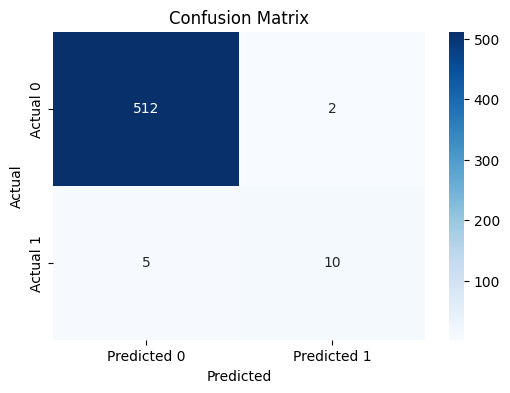

In [ ]:
cm = confusion_matrix(results_df['Actual'], results_df['Predicted'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
misclassified_movies = results_df[results_df['Actual'] != results_df['Predicted']]
pd.merge(data_full[data_full["Movie_Title"].isin(misclassified_movies['Movie_Title'].tolist())][["Movie_Title", "Total_Audience_Count"]], misclassified_movies)

,Movie_Title,Total_Audience_Count,Actual,Predicted,Probability_of_Success
0,과속스캔들,8125843,1,0,0.000209
1,레미제라블,5852681,1,0,0.005053
2,블랙 팬서,5395971,1,0,0.000023
3,인셉션,5827610,1,0,0.003654
4,청년경찰,5616614,1,0,0.395071
5,박수건달,3887729,0,1,0.874959
6,그것만이 내 세상,3395274,0,1,0.788532


## 2) 변수 중요도

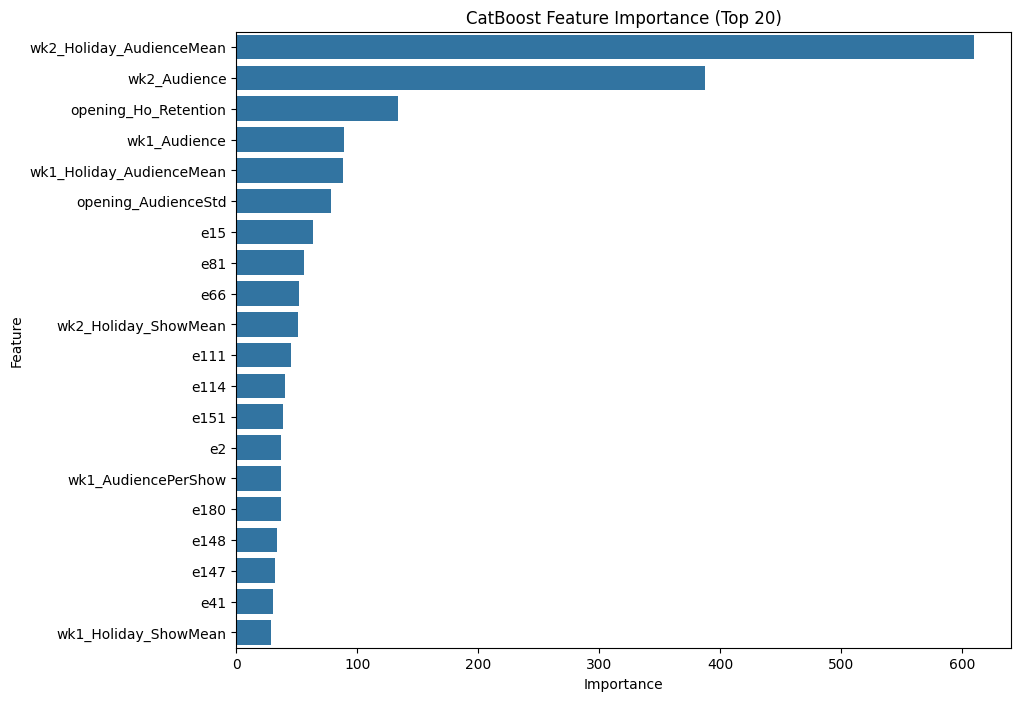

                      Feature  Importance
8    wk2_Holiday_AudienceMean         610
2                wk2_Audience         387
5        opening_Ho_Retention         134
0                wk1_Audience          89
6    wk1_Holiday_AudienceMean          88
10        opening_AudienceStd          78
34                        e15          63
100                       e81          56
85                        e66          52
9        wk2_Holiday_ShowMean          51
130                      e111          45
133                      e114          40
170                      e151          39
21                         e2          37
1         wk1_AudiencePerShow          37
199                      e180          37
167                      e148          34
166                      e147          32
60                        e41          30
7        wk1_Holiday_ShowMean          29


In [ ]:
# 1. 변수 중요도 추출
feature_importances = model.feature_importances_
feature_names = X_train.columns

# 2. 데이터프레임으로 만들기
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 3. 상위 20개 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance (Top 20)')
plt.show()

# 4. 중요도 출력
print(importance_df.head(20))

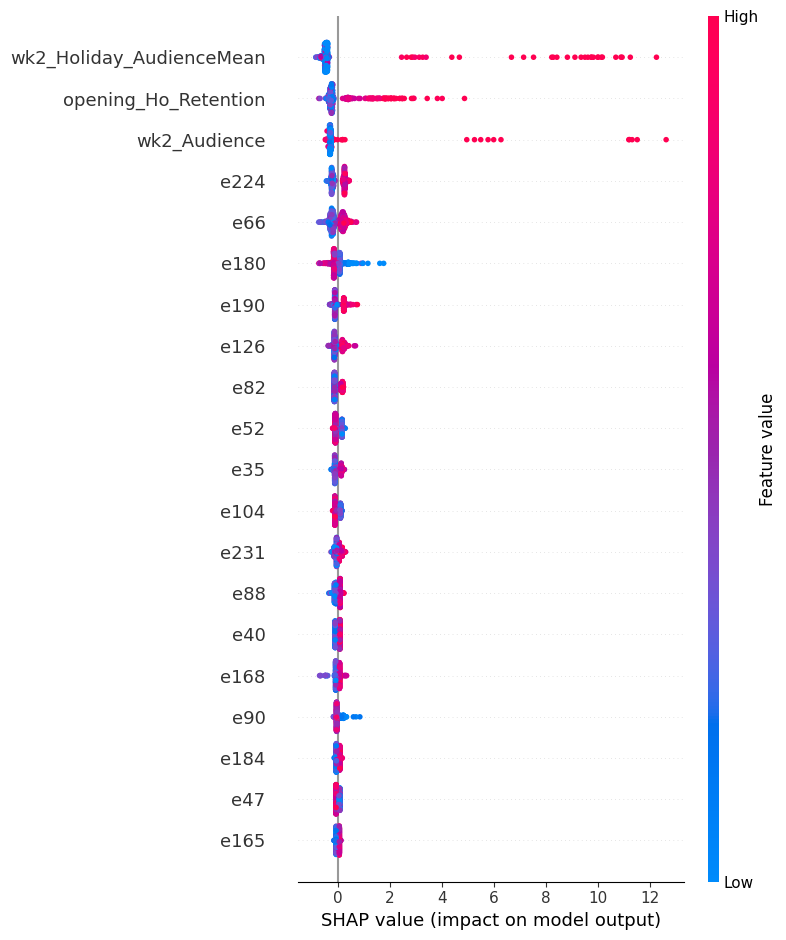

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

1. `wk2_Holiday_AudienceMean`, `wk2_Audience`, `opening_Ho_Retention `
2. `wk1_Holiday_AudienceMean`, `wk1_Audience`, `opening_AudienceStd`, ` wk2_Holiday_ShowMean`, `wk2_AudiencePerShow`

총 3+5개의 변수가 유의

## 3) 변수 선택 및 하이퍼파라미터 튜닝

In [ ]:
feature_sets = {
    "base_3": ['wk2_Holiday_AudienceMean', 'wk2_Audience', 'opening_Ho_Retention'],
    "full_8": ['wk2_Holiday_AudienceMean', 'wk2_Audience', 'opening_Ho_Retention',
               'wk1_Holiday_AudienceMean', 'wk1_Audience', 'opening_AudienceStd', 'wk2_Holiday_ShowMean', 'wk2_AudiencePerShow']
}

embedding_sets = {
    "embed_128": [f'e{i+1}' for i in range(128)],
    "embed_64": [f'e{i+1}' for i in range(64)],
    "embed_32": [f'e{i+1}' for i in range(32)],
    "embed_none" : []
}

tuner_methods = ['optuna', 'random_search']
# tuner_methods = ['random_search', 'optuna']

In [ ]:
# --- 실험 루프 ---
results = []
experiment_id = 0
total_experiments = len(feature_sets) * len(embedding_sets) * len(tuner_methods)

for f_name, f_cols in feature_sets.items():
    for e_name, e_cols in embedding_sets.items():

        # 현재 조합에 사용할 전체 변수 리스트 생성
        current_cols = f_cols + e_cols
        X_train_exp = X_train[current_cols].copy()
        X_test_exp = X_test[current_cols].copy()

        for tuner in tuner_methods:
            experiment_id += 1
            print(f"--- 실험 {experiment_id}/{total_experiments} 진행 중 ---")
            print(f"Features: {f_name}, Embeddings: {e_name}, Tuner: {tuner}")

            best_params = {}

            if tuner == 'optuna':
                def objective(trial):
                    param_optuna = {
                        'objective': 'binary',
                        'metric': 'binary_logloss',

                        'n_estimators': 300,
                        # 'n_estimators': 2,

                        'verbose': -1,
                        'device': 'gpu',
                        'gpu_device_id': 0,

                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                        'max_depth': trial.suggest_int('max_depth', 4, 10),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    }
                    model = lgb.LGBMClassifier(**param_optuna)
                    score = cross_val_score(model, X_train_exp, y_train, cv=3, scoring='f1_macro').mean()
                    return score

                study = optuna.create_study(direction='maximize')

                study.optimize(objective, n_trials=40, show_progress_bar=True)
                # study.optimize(objective, n_trials=2, show_progress_bar=True)

                best_params = study.best_params

            elif tuner == 'random_search':
                param_random = {
                    'learning_rate': uniform(0.01, 0.29),
                    'num_leaves': randint(20, 301),
                    'max_depth': randint(4, 11),
                    'subsample': uniform(0.6, 0.4),
                    'colsample_bytree': uniform(0.6, 0.4),
                    'reg_alpha': uniform(1, 9),
                    'reg_lambda': uniform(1, 9),
                    'min_child_samples': randint(5, 101),
                }

                model = lgb.LGBMClassifier(objective='binary', n_estimators=300, verbose=-1, device='gpu', gpu_device_id=0)
                # model = lgb.LGBMClassifier(objective='binary', n_estimators=2, verbose=-1, device='gpu', gpu_device_id=0)

                random_search = RandomizedSearchCV(
                    model,
                    param_distributions=param_random,

                    n_iter=40,
                    # n_iter=2,

                    cv=3,
                    scoring='f1_macro',
                    random_state=42,
                    verbose=1,
                )
                random_search.fit(X_train_exp, y_train)
                best_params = random_search.best_params_

            # 찾은 최적의 파라미터로 최종 모델 학습
            print(f"{f_name} - {e_name} - {tuner} 최종 모델 학습")
            final_model = lgb.LGBMClassifier(
                objective='binary',

                n_estimators=1000,
                # n_estimators=2,

                device='gpu',
                gpu_device_id=0,
                **best_params
            )
            # fit 할 때 로그 출력 설정 (callbacks)
            final_model.fit(X_train_exp, y_train, callbacks=[lgb.log_evaluation(period=200)])

            # 테스트 데이터로 성능 평가
            preds = final_model.predict(X_test_exp)
            f1 = f1_score(y_test, preds, average='macro')
            accuracy = accuracy_score(y_test, preds)

            # 결과 저장
            results.append({
                "Experiment_ID": experiment_id,
                "Feature_Set": f_name,
                "Embedding_Set": e_name,
                "Tuner": tuner,
                "Test_F1_Macro": f1,
                "Test_Accuracy": accuracy,
                "Best_Params": best_params
            })
            print(f"결과 - F1 Macro: {f1:.4f}, Accuracy: {accuracy:.4f}\n")

--- 실험 1/16 진행 중 ---
Features: base_3, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_3 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.8566, Accuracy: 0.9868

--- 실험 2/16 진행 중 ---
Features: base_3, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_3 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8976, Accuracy: 0.9905

--- 실험 3/16 진행 중 ---
Features: base_3, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_3 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9050, Accuracy: 0.9905

--- 실험 4/16 진행 중 ---
Features: base_3, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_3 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 5/16 진행 중 ---
Features: base_3, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_3 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 6/16 진행 중 ---
Features: base_3, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_3 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9211, Accuracy: 0.9924

--- 실험 7/16 진행 중 ---
Features: base_3, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_3 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.9211, Accuracy: 0.9924

--- 실험 8/16 진행 중 ---
Features: base_3, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_3 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.9211, Accuracy: 0.9924

--- 실험 9/16 진행 중 ---
Features: full_8, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.8976, Accuracy: 0.9905

--- 실험 10/16 진행 중 ---
Features: full_8, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 11/16 진행 중 ---
Features: full_8, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.8817, Accuracy: 0.9887

--- 실험 12/16 진행 중 ---
Features: full_8, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9211, Accuracy: 0.9924

--- 실험 13/16 진행 중 ---
Features: full_8, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9050, Accuracy: 0.9905

--- 실험 14/16 진행 중 ---
Features: full_8, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.8899, Accuracy: 0.9887

--- 실험 15/16 진행 중 ---
Features: full_8, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.8899, Accuracy: 0.9887

--- 실험 16/16 진행 중 ---
Features: full_8, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.9050, Accuracy: 0.9905



In [ ]:
# --- 4. 최종 결과 취합 및 출력 ---
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Test_F1_Macro', ascending=False)

print("========== 최종 실험 결과 (F1 Score 기준 정렬) ==========")
print(results_df_sorted)

========== 최종 실험 결과 (F1 Score 기준 정렬) ==========
    Experiment_ID Feature_Set Embedding_Set          Tuner  Test_F1_Macro  \
6               7      base_3    embed_none         optuna       0.921139   
7               8      base_3    embed_none  random_search       0.921139   
5               6      base_3      embed_32  random_search       0.921139   
11             12      full_8      embed_64  random_search       0.921139   
12             13      full_8      embed_32         optuna       0.904983   
15             16      full_8    embed_none  random_search       0.904983   
2               3      base_3      embed_64         optuna       0.904983   
1               2      base_3     embed_128  random_search       0.897580   
8               9      full_8     embed_128         optuna       0.897580   
13             14      full_8      embed_32  random_search       0.889945   
14             15      full_8    embed_none         optuna       0.889945   
3               4      base_

## 4) 최종 모델 생성

In [ ]:
# --- 5. 최고 성능 모델 재학습 및 저장 (LightGBM 버전) ---
print("\n========== 최고 성능 모델 재학습 및 저장 ==========")

# 5-1. 가장 점수가 높았던 실험의 설정 가져오기
best_experiment = results_df_sorted.iloc[0]
best_f_name = best_experiment['Feature_Set']
best_e_name = best_experiment['Embedding_Set']
best_params = best_experiment['Best_Params']

print(f"최고 성능 조합: Features='{best_f_name}', Embeddings='{best_e_name}'")
print(f"최고 성능 하이퍼파라미터: {best_params}")

# 5-2. 최고 성능 조합에 맞는 전체 데이터 준비
best_f_cols = feature_sets[best_f_name]
best_e_cols = embedding_sets[best_e_name]
best_current_cols = best_f_cols + best_e_cols

# 전체 데이터 X에서 최고 성능의 변수들만 선택
X_best_features = X[best_current_cols].copy() # .copy() 추가

# 5-3. 최고 성능 파라미터로 최종 모델 생성
best_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    device='gpu',
    gpu_device_id=0,
    **best_params
)

print("\n최고 성능 모델 전체 데이터로 재학습 시작...")
# 전체 데이터(X_best_features, y)로 최종 학습
best_model.fit(
    X_best_features,
    y,
    callbacks=[lgb.log_evaluation(period=200)] # verbose -> callbacks
)
print("재학습 완료.")

# 5-4. 모델 파일로 저장 (★★ LightGBM 핵심 부분 ★★)
# .booster_ 속성을 통해 LightGBM의 핵심 모델에 접근하여 저장합니다.
best_model.booster_.save_model("/content/drive/MyDrive/비어플/25-2/model/lightgbm_model_5m.txt")
print("최고 성능 모델을 'lightgbm_model_10k.txt' 파일로 저장했습니다. 💾")


========== 최고 성능 모델 재학습 및 저장 ==========
최고 성능 조합: Features='base_3', Embeddings='embed_none'
최고 성능 하이퍼파라미터: {'learning_rate': 0.06398374601843189, 'num_leaves': 300, 'max_depth': 5, 'subsample': 0.8483074793478456, 'colsample_bytree': 0.6648295066168521, 'reg_alpha': 7.20665738233704, 'reg_lambda': 1.1661611886993247e-05, 'min_child_samples': 28}

최고 성능 모델 전체 데이터로 재학습 시작...
재학습 완료.
최고 성능 모델을 'lightgbm_model_10k.txt' 파일로 저장했습니다. 💾
